# 06.1r: Singularity Sky Map

**Goal:** Test the hypothesis that the blue stripe in early sky maps is the black hole cluster + cuckoos, and the black voids are the exclusion zone.

We'll create a sky map colored by zone membership:
- **Red:** Black holes (2,100 degenerate tokens at r < 1e-4 from BH centroid)
- **Yellow:** Cuckoos (27 tokens at 1e-4 < r < 1e-3 from BH centroid)
- **Green:** Exclusion zone (tokens at 1e-3 < r < 1e-2 from BH centroid)
- **Blue:** Bulk (everything else)

Parameterizable zoom and heading like 04.1a to explore different patches of sky.

**Hypothesis:** If PC1 points toward the black hole cluster, the stripe should appear as a line at constant latitude, with black holes + cuckoos forming a dense wall and the exclusion zone appearing as a depleted band.

This is Volume 6: Pathologies and Singularities

## Parameters

In [38]:
TENSOR_DIR = "../data/tensors"
GAMMA_FILE = "gamma_qwen3_4b_instruct_2507.safetensors"

# Coordinate system: which PC axes define our spherical coordinates?
NORTH_PC = 1
MERIDIAN_PC = 2
EQUINOX_PC = 3

# Viewing direction: rotate plot so this longitude is centered
HEADING = 0

# Zoom: set specific ranges for plot
# Set to None to show full sky
LON_MIN = 164  # e.g., 164
LON_MAX = 165  # e.g., 165
LAT_MIN = 5  # e.g., 5
LAT_MAX = 15  # e.g., 15

# Zone boundaries (distances from black hole centroid)
BLACK_HOLE_R = 1e-4
CUCKOO_R = 1e-3
EXCLUSION_R = 1e-2

# Visualization
POINT_SIZE = 1
POINT_ALPHA = 1
FIGURE_DPI = 100

# Random seed
RANDOM_SEED = 42

## Imports

In [22]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Data and Identify Black Hole Centroid

In [23]:
print("Loading gamma matrix...")
gamma_path = Path(TENSOR_DIR) / GAMMA_FILE
gamma = load_file(gamma_path)['gamma']
N, d = gamma.shape
print(f"Loaded: {gamma.shape}\n")

print("Finding degenerate clusters...\n")

gamma_np = gamma.cpu().numpy()
unique_vecs, inverse_indices, counts = np.unique(
    gamma_np, 
    axis=0, 
    return_inverse=True, 
    return_counts=True
)

# Build clusters
clusters = defaultdict(list)
for token_id, unique_idx in enumerate(inverse_indices):
    clusters[unique_idx].append(token_id)

# Filter to degenerate clusters
degenerate_clusters = {idx: tokens for idx, tokens in clusters.items() if len(tokens) > 1}

# Sort by size, descending
sorted_clusters = sorted(degenerate_clusters.items(), key=lambda x: len(x[1]), reverse=True)

# Extract all black hole token IDs (top 13 clusters)
black_hole_token_ids = []
for unique_idx, token_ids in sorted_clusters[:13]:
    black_hole_token_ids.extend(token_ids)

black_hole_token_ids = sorted(black_hole_token_ids)
black_hole_set = set(black_hole_token_ids)

print(f"Identified {len(black_hole_token_ids)} black hole tokens")

# Compute centroid
black_hole_embeddings = gamma[black_hole_token_ids]
bh_centroid = black_hole_embeddings.mean(dim=0)
bh_centroid_norm = torch.norm(bh_centroid)

print(f"Black hole centroid norm: {bh_centroid_norm.item():.12f}")

Loading gamma matrix...
Loaded: torch.Size([151936, 2560])

Finding degenerate clusters...

Identified 2100 black hole tokens
Black hole centroid norm: 0.370916873217


## Step 2: Classify All Tokens by Zone

In [24]:
print("\n" + "="*70)
print("CLASSIFYING TOKENS BY ZONE")
print("="*70)
print()

# Compute distances from black hole centroid
distances_from_bh = torch.norm(gamma - bh_centroid, dim=1)

# Classify into zones
black_hole_mask = distances_from_bh <= BLACK_HOLE_R
cuckoo_mask = (distances_from_bh > BLACK_HOLE_R) & (distances_from_bh <= CUCKOO_R)
exclusion_mask = (distances_from_bh > CUCKOO_R) & (distances_from_bh <= EXCLUSION_R)
bulk_mask = distances_from_bh > EXCLUSION_R

n_black_holes = black_hole_mask.sum().item()
n_cuckoos = cuckoo_mask.sum().item()
n_exclusion = exclusion_mask.sum().item()
n_bulk = bulk_mask.sum().item()

print(f"Zone populations:")
print(f"  Black holes (r < {BLACK_HOLE_R:.0e}): {n_black_holes:,} ({n_black_holes/N*100:.4f}%)")
print(f"  Cuckoos ({BLACK_HOLE_R:.0e} < r < {CUCKOO_R:.0e}): {n_cuckoos:,} ({n_cuckoos/N*100:.4f}%)")
print(f"  Exclusion zone ({CUCKOO_R:.0e} < r < {EXCLUSION_R:.0e}): {n_exclusion:,} ({n_exclusion/N*100:.4f}%)")
print(f"  Bulk (r > {EXCLUSION_R:.0e}): {n_bulk:,} ({n_bulk/N*100:.2f}%)")
print(f"\nTotal: {n_black_holes + n_cuckoos + n_exclusion + n_bulk:,}")


CLASSIFYING TOKENS BY ZONE

Zone populations:
  Black holes (r < 1e-04): 2,183 (1.4368%)
  Cuckoos (1e-04 < r < 1e-03): 27 (0.0178%)
  Exclusion zone (1e-03 < r < 1e-02): 11 (0.0072%)
  Bulk (r > 1e-02): 149,715 (98.54%)

Total: 151,936


## Step 3: Center at Cloud Centroid and Compute PCA

In [25]:
print("\n" + "="*70)
print("COMPUTING GAMMA PRIME (CENTERED AT CLOUD CENTROID)")
print("="*70)
print()

# Compute cloud centroid
cloud_centroid = gamma.mean(dim=0)
cloud_centroid_norm = torch.norm(cloud_centroid)

print(f"Cloud centroid norm: {cloud_centroid_norm.item():.12f}")
print(f"Black hole centroid norm: {bh_centroid_norm.item():.12f}")
print(f"Distance between centroids: {torch.norm(bh_centroid - cloud_centroid).item():.12f}")
print()

# Center at cloud centroid
gamma_prime = gamma - cloud_centroid

print("Computing covariance matrix...")
Cov = (gamma_prime.T @ gamma_prime) / (N - 1)

print(f"Computing eigendecomposition...\n")
eigenvalues, eigenvectors = torch.linalg.eigh(Cov)

# Sort descending (highest variance first)
eigenvalues = eigenvalues.flip(0)
eigenvectors = eigenvectors.flip(1)

print(f"Top 10 eigenvalues:")
for i in range(10):
    variance_explained = eigenvalues[i] / eigenvalues.sum()
    print(f"  PC{i+1}: λ = {eigenvalues[i].item():.6e} ({variance_explained.item()*100:.2f}%)")

print(f"\nPCA computed successfully.")


COMPUTING GAMMA PRIME (CENTERED AT CLOUD CENTROID)

Cloud centroid norm: 0.304777026176
Black hole centroid norm: 0.370916873217
Distance between centroids: 0.166060894728

Computing covariance matrix...
Computing eigendecomposition...

Top 10 eigenvalues:
  PC1: λ = 1.048719e-02 (0.94%)
  PC2: λ = 3.177739e-03 (0.28%)
  PC3: λ = 2.791374e-03 (0.25%)
  PC4: λ = 2.616169e-03 (0.23%)
  PC5: λ = 1.973001e-03 (0.18%)
  PC6: λ = 1.805293e-03 (0.16%)
  PC7: λ = 1.609086e-03 (0.14%)
  PC8: λ = 1.549411e-03 (0.14%)
  PC9: λ = 1.468294e-03 (0.13%)
  PC10: λ = 1.389096e-03 (0.12%)

PCA computed successfully.


## Step 4: Test Hypothesis - Does PC1 Point Toward Black Hole Centroid?

In [26]:
print("\n" + "="*70)
print("TESTING HYPOTHESIS: DOES PC1 POINT TOWARD BLACK HOLE CLUSTER?")
print("="*70)
print()

# PC1 is the first eigenvector (column 0)
pc1 = eigenvectors[:, 0]

# Direction from cloud centroid to black hole centroid (in gamma prime space)
bh_direction = bh_centroid - cloud_centroid
bh_direction_normalized = bh_direction / torch.norm(bh_direction)

# Compute angle between PC1 and BH direction
cosine_sim = (pc1 @ bh_direction_normalized).item()
angle_rad = torch.acos(torch.clamp(torch.tensor(cosine_sim), -1.0, 1.0))
angle_deg = torch.rad2deg(angle_rad).item()

print(f"PC1 · BH_direction: {cosine_sim:.6f}")
print(f"Angle: {angle_deg:.4f}°")
print()

if abs(cosine_sim) > 0.9:  # Within ~25° of alignment
    if cosine_sim > 0:
        print("✅ PC1 POINTS TOWARD THE BLACK HOLE CLUSTER!")
    else:
        print("✅ PC1 POINTS AWAY FROM THE BLACK HOLE CLUSTER (180° flip)!")
    print("The hypothesis is SUPPORTED: the cloud's principal axis is defined by the singularity.")
else:
    print(f"❌ PC1 is at {angle_deg:.1f}° from the black hole direction.")
    print("The hypothesis is NOT supported.")


TESTING HYPOTHESIS: DOES PC1 POINT TOWARD BLACK HOLE CLUSTER?

PC1 · BH_direction: 0.292408
Angle: 72.9978°

❌ PC1 is at 73.0° from the black hole direction.
The hypothesis is NOT supported.


## Step 5: Convert to Spherical Coordinates

In [27]:
print("\n" + "="*70)
print("CONVERTING TO SPHERICAL COORDINATES")
print("="*70)
print()

# Extract basis vectors
north_vector = eigenvectors[:, NORTH_PC - 1]
meridian_vector = eigenvectors[:, MERIDIAN_PC - 1]
equinox_vector = eigenvectors[:, EQUINOX_PC - 1]

print(f"Coordinate system:")
print(f"  North pole: PC{NORTH_PC}")
print(f"  Prime meridian: PC{MERIDIAN_PC}")
print(f"  Equinox: PC{EQUINOX_PC}")
print()

# Project onto basis vectors
x = gamma_prime @ meridian_vector
y = gamma_prime @ equinox_vector
z = gamma_prime @ north_vector

# Compute spherical coordinates
r = torch.sqrt(x**2 + y**2 + z**2)
theta_rad = torch.asin(torch.clamp(z / r, -1, 1))
theta_deg = torch.rad2deg(theta_rad)
phi_rad = torch.atan2(y, x)
phi_deg = torch.rad2deg(phi_rad)

print(f"Latitude statistics (before CDF flattening):")
print(f"  Mean: {theta_deg.mean().item():.6f}°")
print(f"  Std: {theta_deg.std().item():.6f}°")
print(f"  Min: {theta_deg.min().item():.6f}°")
print(f"  Max: {theta_deg.max().item():.6f}°")


CONVERTING TO SPHERICAL COORDINATES

Coordinate system:
  North pole: PC1
  Prime meridian: PC2
  Equinox: PC3

Latitude statistics (before CDF flattening):
  Mean: 5.255265°
  Std: 49.628139°
  Min: -89.923386°
  Max: 89.680405°


## Step 6: Apply CDF Flattening to Latitude

In [28]:
print("\n" + "="*70)
print("APPLYING CDF FLATTENING")
print("="*70)
print()

# Sort latitudes to compute empirical CDF
theta_sorted, sort_indices = torch.sort(theta_deg)

# Empirical CDF values
cdf_values = torch.linspace(0, 1, N)

# Map CDF to uniform [-90°, +90°] range
theta_flat_sorted = 90.0 * (2.0 * cdf_values - 1.0)

# Unsort
theta_flat = torch.zeros_like(theta_deg)
theta_flat[sort_indices] = theta_flat_sorted

print(f"CDF flattening complete.")
print(f"\nFlattened latitude statistics:")
print(f"  Mean: {theta_flat.mean().item():.6f}°")
print(f"  Std: {theta_flat.std().item():.6f}°")
print(f"  Min: {theta_flat.min().item():.6f}°")
print(f"  Max: {theta_flat.max().item():.6f}°")


APPLYING CDF FLATTENING

CDF flattening complete.

Flattened latitude statistics:
  Mean: -0.000001°
  Std: 51.962036°
  Min: -90.000000°
  Max: 90.000000°


## Step 7: Apply Heading Rotation

In [29]:
# Shift longitude by HEADING degrees
phi_rotated = phi_deg - HEADING

# Wrap to [-180°, +180°] range
phi_rotated = torch.where(phi_rotated > 180, phi_rotated - 360, phi_rotated)
phi_rotated = torch.where(phi_rotated < -180, phi_rotated + 360, phi_rotated)

print(f"Applied heading rotation: {HEADING}°")

Applied heading rotation: 0°


## Step 8: Create Zone-Colored Sky Map


CREATING SKY MAP



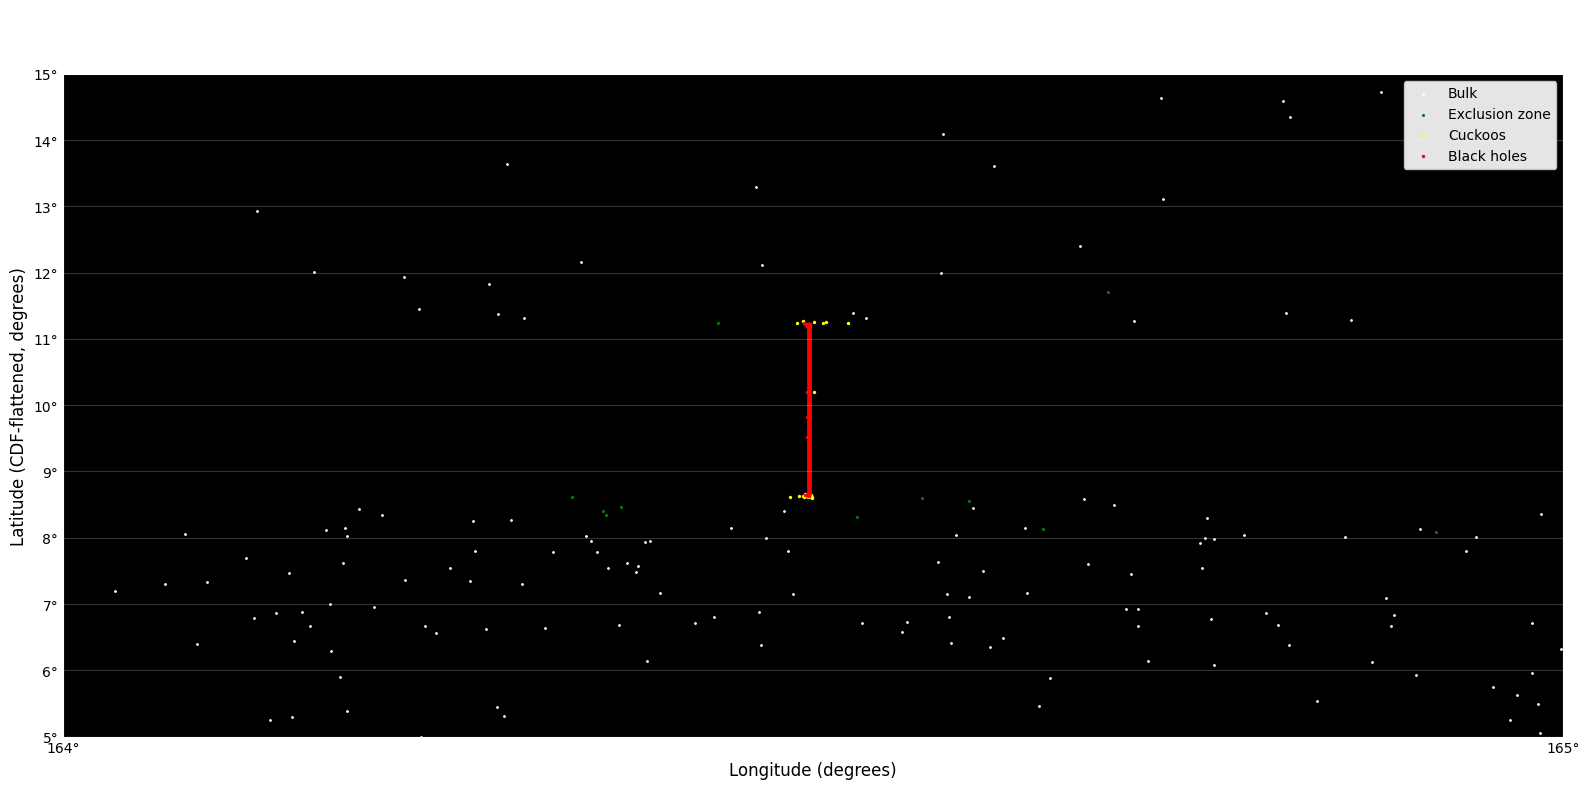


Sky map complete.
  Zoom: Longitude [164°, 165°], Latitude [5°, 15°]
  Red: 2,183 black holes
  Yellow: 27 cuckoos
  Green: 11 exclusion zone tokens
  Blue: 149,715 bulk tokens


In [39]:
print("\n" + "="*70)
print("CREATING SKY MAP")
print("="*70)
print()

# Convert to numpy
phi_np = phi_rotated.cpu().numpy()
theta_flat_np = theta_flat.cpu().numpy()
black_hole_np = black_hole_mask.cpu().numpy()
cuckoo_np = cuckoo_mask.cpu().numpy()
exclusion_np = exclusion_mask.cpu().numpy()
bulk_np = bulk_mask.cpu().numpy()

# Create figure
fig, ax = plt.subplots(figsize=(16, 8), dpi=FIGURE_DPI)
ax.set_facecolor('black')

# Plot in order: bulk first (background), then exclusion, then cuckoos, then black holes (foreground)
ax.scatter(phi_np[bulk_np], theta_flat_np[bulk_np],
           s=POINT_SIZE, alpha=POINT_ALPHA, c='white', label='Bulk', rasterized=True)

ax.scatter(phi_np[exclusion_np], theta_flat_np[exclusion_np],
           s=POINT_SIZE*1.5, alpha=POINT_ALPHA, c='green', label='Exclusion zone', rasterized=True)

ax.scatter(phi_np[cuckoo_np], theta_flat_np[cuckoo_np],
           s=POINT_SIZE*2, alpha=POINT_ALPHA, c='yellow', label='Cuckoos', rasterized=True)

ax.scatter(phi_np[black_hole_np], theta_flat_np[black_hole_np],
           s=POINT_SIZE*2, alpha=POINT_ALPHA, c='red', label='Black holes', rasterized=True)

# Determine plot limits
lon_min = LON_MIN if LON_MIN is not None else -180
lon_max = LON_MAX if LON_MAX is not None else 180
lat_min = LAT_MIN if LAT_MIN is not None else -90
lat_max = LAT_MAX if LAT_MAX is not None else 90

# Set tick spacing
lon_range = lon_max - lon_min
lat_range = lat_max - lat_min

if lon_range <= 20:
    lon_tick_spacing = 1
elif lon_range <= 60:
    lon_tick_spacing = 5
else:
    lon_tick_spacing = 15

if lat_range <= 20:
    lat_tick_spacing = 1
elif lat_range <= 60:
    lat_tick_spacing = 5
else:
    lat_tick_spacing = 10

lon_ticks = np.arange(
    np.ceil(lon_min / lon_tick_spacing) * lon_tick_spacing,
    lon_max + lon_tick_spacing,
    lon_tick_spacing
)
lat_ticks = np.arange(
    np.ceil(lat_min / lat_tick_spacing) * lat_tick_spacing,
    lat_max + lat_tick_spacing,
    lat_tick_spacing
)

ax.set_xticks(lon_ticks)
ax.set_yticks(lat_ticks)
ax.set_xticklabels([f'{int(lon)}°' for lon in lon_ticks])
ax.set_yticklabels([f'{int(lat)}°' for lat in lat_ticks])
ax.tick_params(axis='both', which='both', length=0, colors='black')

ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
ax.grid(True, alpha=0.2, color='white', which='major')

ax.set_xlabel('Longitude (degrees)', color='black', fontsize=12)
ax.set_ylabel('Latitude (CDF-flattened, degrees)', color='black', fontsize=12)

# Title
if LON_MIN is not None or LAT_MIN is not None:
    title = f'Singularity Sky Map (North=PC{NORTH_PC}, Meridian=PC{MERIDIAN_PC}, Heading={HEADING}°)\n'
    title += f'Zoom: Lon [{lon_min}°, {lon_max}°], Lat [{lat_min}°, {lat_max}°]'
else:
    title = f'Singularity Sky Map (North=PC{NORTH_PC}, Meridian=PC{MERIDIAN_PC}, Heading={HEADING}°)'

ax.set_title(title, color='white', pad=20, fontsize=14)

for spine in ax.spines.values():
    spine.set_edgecolor('white')

# Legend with opaque markers
legend = ax.legend(loc='upper right', framealpha=0.9, fontsize=10)
for handle in legend.legend_handles:
    handle.set_alpha(1.0)

plt.tight_layout()
plt.show()

print(f"\nSky map complete.")
if LON_MIN is not None or LAT_MIN is not None:
    print(f"  Zoom: Longitude [{lon_min}°, {lon_max}°], Latitude [{lat_min}°, {lat_max}°]")
print(f"  Red: {n_black_holes:,} black holes")
print(f"  Yellow: {n_cuckoos:,} cuckoos")
print(f"  Green: {n_exclusion:,} exclusion zone tokens")
print(f"  Blue: {n_bulk:,} bulk tokens")

## Summary

We tested the hypothesis that the blue stripe in early sky maps is the black hole cluster + cuckoos.

**Method:**
1. Classified all tokens by distance from black hole centroid
2. Computed PCA on cloud-centered coordinates
3. Tested if PC1 points toward black hole cluster
4. Created sky map colored by zone membership

**Zones:**
- **Red:** Black holes (r < 1e-4 from BH centroid)
- **Yellow:** Cuckoos (1e-4 < r < 1e-3)
- **Green:** Exclusion zone (1e-3 < r < 1e-2)
- **Blue:** Bulk (r > 1e-2)

**If hypothesis is correct:** 
- Red + yellow tokens should form a horizontal stripe at constant latitude
- Black voids above/below should correspond to sparse green (exclusion zone)
- PC1 should point toward (or away from) black hole cluster